In [4]:
from astropy.io import fits
from astropy.wcs import WCS
import png
import numpy as np
from utils import zscale
import matplotlib.pyplot as plt
import math
import scipy
from os import listdir
from os.path import isfile, join
import cupy as cp

DATA_PATH = 'SatSimPNG'
TOTAL_VELOCITY_VECTORS = 1000
IMAGES_TO_STACK = [DATA_PATH + '/' + f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
NUM_FRAMES = len(IMAGES_TO_STACK)
DIMENSIONS = (512, 512)

In [3]:
#Convert all images to greyscale
from PIL import Image

for path in IMAGES_TO_STACK:
    img = Image.open(path).convert('L')
    img.save(path[:-3]+'png')

Prints out all images to be stacked

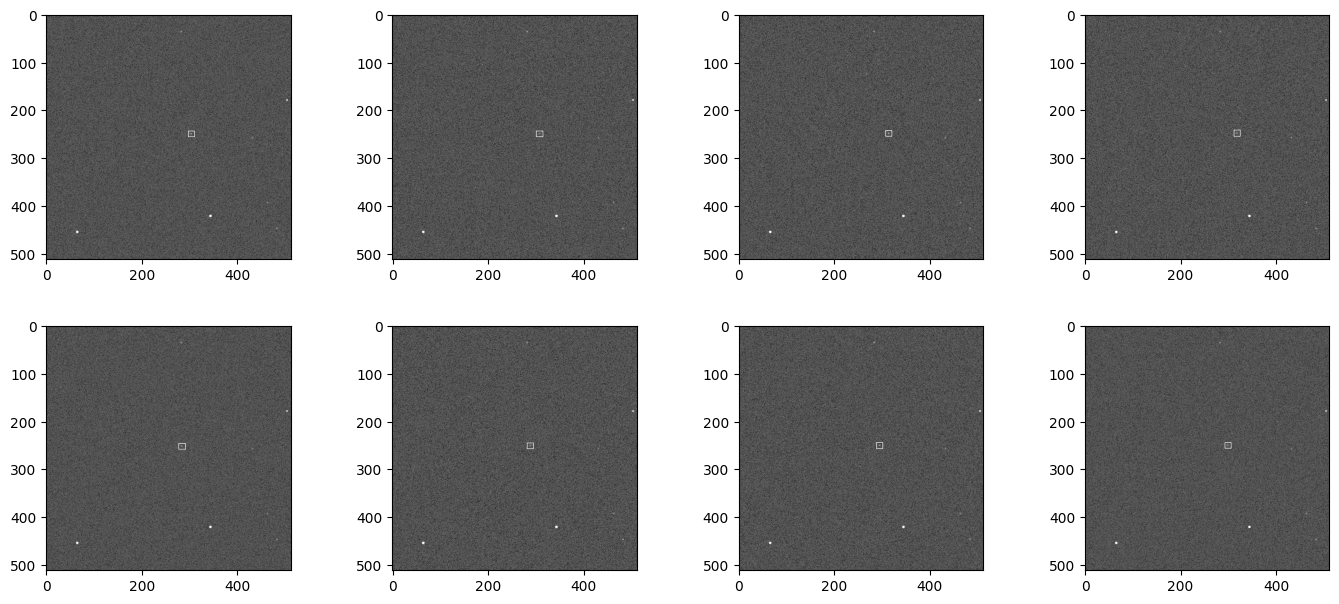

In [7]:
plt.rcParams["figure.figsize"] = [14.00, 15.00]
plt.rcParams["figure.autolayout"] = True

total_images = len(IMAGES_TO_STACK)
row_counter = 1
column_counter = 1
for file in IMAGES_TO_STACK:
    plt.subplot(row_counter, 4, column_counter)
    plt.imshow(np.vstack(list(map(np.uint16, png.Reader(file).asDirect()[2]))), cmap="Greys_r")
    column_counter += 1
    if column_counter > 4:
        column_counter = 1
        row_counter += 1

Creates the predictive velocity vectors in which shifts will be applied

In [8]:
#For rounding
a = int(math.sqrt(TOTAL_VELOCITY_VECTORS)) 
b = math.floor(a/2)
if a % 2 == 0:
    a += 1

velocities = cp.zeros(shape = (a * a, 2))
vel_to_idx = {}

idx = 0
for i in range(-b, b+1):
    for j in range(-b, b+1):
        vel_to_idx[(i,j)] = idx
        velocities[idx] = cp.asarray([i,j])
        idx += 1

print('A total of ' + str(a * a) + ' velocities will be tested.')
print('Range of velocity for both x and y direction: ' + str([-b, b]))

A total of 961 velocities will be tested.
Range of velocity for both x and y direction: [-15, 15]


In [9]:
from cupyx.scipy import ndimage

def stack(file_paths: list, velocity_vector):
    '''
    Inputs:
        file_path is a list of strings refering to the images that are to be stacked
        
        velocity_vector is a 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.

    Output:
        a stacked image of all frames.
    '''
    final_dimensions = DIMENSIONS
    stacked_image = cp.zeros(shape=final_dimensions)
    iter = 0
    init_x_vel = velocity_vector[0]
    init_y_vel = velocity_vector[1]

    for img in file_paths:
        image_data = png.Reader(img).asDirect()
        image = cp.vstack(list(map(cp.uint16, image_data[2])))
        img_shifted = ndimage.shift(image, velocity_vector, mode='constant')
        if iter != 0:
            stacked_image += img_shifted
        iter += 1
        velocity_vector = [init_y_vel * iter, init_x_vel * iter]
    return stacked_image

Example usage of the stack function with velocity vector [0, -3]

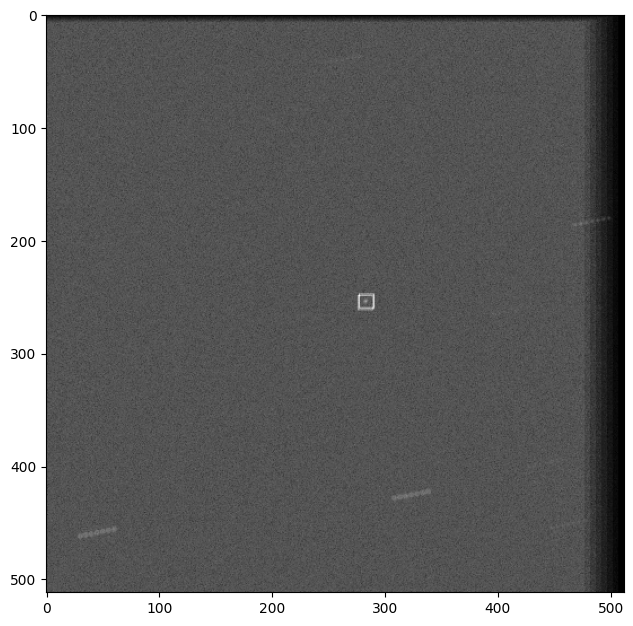

In [26]:
plt.rcParams["figure.figsize"] = [7.5, 7.5]
plt.rcParams["figure.autolayout"] = False
final = stack(IMAGES_TO_STACK, [-5., 1])
plt.imshow((cp.ndarray.get(final)), cmap="Greys_r")

In [109]:
def build_data_cube(file_paths, all_vectors):
    '''
    Creates a dictionary of stacked frames for each velocity vector

    Inputs: file_path is a list of strings refering to the images that are to be stacked

    all_vectors is a list of 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.
    
    Output: a dictionary of the final stacked frames where the velocity vector in tuple 
        form is the key for retreiving a stacked image.
    '''
    data_cube = []
    for velocity in all_vectors:
        stacked_image = stack(file_paths=file_paths, velocity_vector=velocity)
        data_cube.append(stacked_image)
    return data_cube

data_cube = build_data_cube(IMAGES_TO_STACK, velocities)

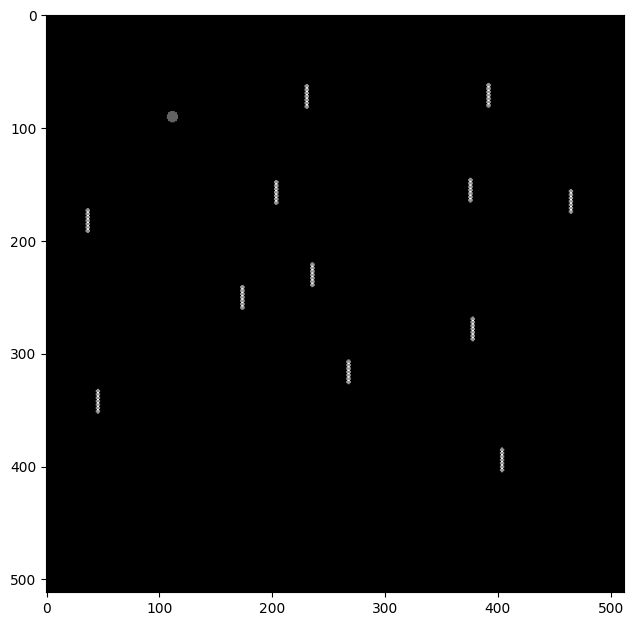

In [99]:
vel_vec = (0, -3)
idx = vel_to_idx[vel_vec]
img = data_cube[idx]
plt.imshow(cp.ndarray.get(img), cmap="Greys_r")